# The steps to generate boxplots for full lifecycle costs from CACTUS database

## 1. Define 10 patterns of CACTUS components' combinations. Every pattern should be consist of 3 to 4 components over the sanitation value chain as follows.

  - containment, emptying, transporting and treatment
  - containment, emptying and transport, treatment
## 2. Extract TACH values for each component and summing full lifecycle costs for all combinations for each pattern defined in step 1 

## 3. Draw boxplots from the result of step 3

## Common variables for figure

In [5]:
# variables
path_excel = r'data.xlsx'
sheet_name = 'cactus_data'
file_path = 'images/Figure2 fulllifecycle_cost_comparison_global.pdf'
dpi = 700

labelFontSize = 18
legendFontSize = 20

ytickLabel = 'Total Annualised Cost per Household (TACH) Int$ (2020)'
ytick_range = [
    0,    # min
    2600, # max
    250   # interval
]

colors = [
    '#FFD580', # light orange color
    '#90EE90', # light green color
]

## 1. Define 10 patterns of CACTUS components' combinations. Every pattern should be consist of 3 to 4 components over the sanitation value chain

In [6]:
combinations = [
    [ 
        'Infiltrating pit', 
        None, 
        'Wheels - Machine Powered', 
        'Machine-powered aerobic waste water',
        'Infiltrating pit, Wheels - Machine Powered, Machine-powered aerobic waste water',
        colors[0]
    ],
    [ 
        'Infiltrating pit', 
        None, 
        'Wheels - Machine Powered', 
        'Passive aerobic waste water',
        'Infiltrating pit, Wheels - Machine Powered, Passive aerobic waste water',
        colors[1]
    ],
    [ 
        'Sealed tank without infiltration structure', 
        None, 
        'Wheels - Machine Powered', 
        'Machine-powered aerobic waste water',
        'Sealed tank without infiltration structure, Wheels - Machine Powered, Machine-powered aerobic waste water',
        colors[0]
    ],
    [ 
        'Sealed tank without infiltration structure', 
        None, 
        'Wheels - Machine Powered', 
        'Passive aerobic waste water',
        'Sealed tank without infiltration structure, Wheels - Machine Powered, Passive aerobic waste water',
        colors[1]
    ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, combined, with pumping', 
        'Machine-powered aerobic waste water',
        'Direct, Conventional pipes combined with pumping, Machine-powered aerobic waste water',
        colors[0]
    ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, combined, with pumping', 
        'Passive aerobic waste water',
        'Direct, Conventional pipes combined with pumping, Passive aerobic waste water',
        colors[1]
    ],
    # note. the following two combinations does not have actual data for combined converntional pipe without pumping in the database.
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, combined, no pumping', 
        'Machine-powered aerobic waste water',
        'Direct, Conventional pipes combined without pumping, Machine-powered aerobic waste water',
        colors[0]
    ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, combined, no pumping', 
        'Passive aerobic waste water',
        'Direct, Conventional pipes combined without pumping, Passive aerobic waste water',
        colors[1]
    ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, separate, with pumping', 
        'Machine-powered aerobic waste water',
        'Direct, Conventional pipes separate with pumping, Machine-powered aerobic waste water',
        colors[0]
    ],
    [ 
        'Direct', 
        None, 
        'Pipes - conventional, separate, with pumping', 
        'Passive aerobic waste water',
        'Direct, Conventional pipes separate with pumping, Passive aerobic waste water',
        colors[1]
    ],
]

## Importing requires python packages

In [7]:
import pandas as pd
import itertools
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.text import Text
import textwrap
import matplotlib.patches as mpatches
from matplotlib.path import Path

## Define python functions

### Function 1) Defining the function to get all TACHs by filtering the given component name

In [8]:
def getTachsByComponentName(df, name):
    """
    get all TACHs by filtering the given component name
    
    Parameters
    ----------
    df : dataframe
    name: component name
    
    Returns
    -------
        the list of TACH values for the given component
    """
    if not name:
        return []
    filter = df.component == name
    return list(df[filter]['tach'])

### Function 2)  Defining the function to estimate lifecycle cost by given combination of CACTUS components

This function is going to estimate full lifecycle cost by the givern component names (containment, emptying, transporting and treatment)
- extract the list of TACH values by component names
- estimate SUM value for each combination

In [9]:
def getLifecycleCostsbyCombination(df, container_name, emptying_name, transport_name, treatment_name, label, color):
    """
    Estimate lifecycle cost by given combination of CACTUS components
    
    Parameters
    ----------
    df : dataframe
    container_name: container component name
    emptying_name: emptying component name (if no, set NULL)
    transport_name: transport component name (or E&T component name)
    treatment_name: treatment component name
    label: label to be appeared in figure
    color: color for boxplot
    
    Returns
    -------
        returns the dataframe of containing data label and full lifecycle cost values
    """
    # extract the list of TACH values by component names
    container = getTachsByComponentName(df, container_name)
    transport = getTachsByComponentName(df, transport_name)
    treatment = getTachsByComponentName(df, treatment_name)

    if emptying_name:
        emptying = getTachsByComponentName(df, emptying_name)
        
        if len(transport) > 0:
            combinations = list(itertools.product(container, emptying, transport, treatment))  
        else:
            combinations = list(itertools.product(container, emptying, treatment))  
    else:
        if len(transport) > 0:
            combinations = list(itertools.product(container, transport, treatment))
        else:
            combinations = list(itertools.product(container, treatment))
        
    # estimate SUM value for each combination
    sum_array = [round(sum(combination),0) for combination in combinations]  
    sum_array = list(set(sum_array))
    
    # set label in dataframe
    if label:
        name = label
    else:
        if emptying_name:
            name = f"{container_name}, {emptying_name}, {transport_name} and {treatment_name}"
        else:
            name = f"{container_name}, {transport_name} and {treatment_name}"
    names = np.full(len(sum_array), name)
    
    result_df = pd.DataFrame({'name': names, 'tach': sum_array, 'color': color})

    return result_df

### Function 3) Defining the function to show data label

In [10]:
def showLabel(ax, x, y, value):
    """
    Draw data label in the givern X/Y coordinates on the canvas
    
    Parameters
    ----------
    ax : figure canvas object
    x: x coordinate
    y: y coordinate
    value: data value to be shown as label
    """
    ax.text(x, y, f"{value:.0f}", ha='center', va='center', fontsize=14)

### Function 4) Defining the function to draw boxplot in canvas

In [19]:
def drawBoxplot(ax, tachs, position, color, showmeans=True, showfliers=False):
    """
    Draw boxplot by given TACH values in the specified position
    
    Parameters
    ----------
    ax : figure canvas object
    tachs: the list of TACH values
    position: the integer value for the position to draw boxplot
    color: color of boxplot. eg., 'red', 'blue', etc.
    showmeans: show means in boxplot
    showfliers: show outlier values in boxplot
    """
    
    size = len(tachs)
    linestyle = '-'

    if size == 1:
        # If only has 1 value, plot it as marker
        ax.plot(position, tachs, marker='o', color='k', markersize=6)
    else:
        # draw box plots if it has more than two values
        bp = ax.boxplot(
            tachs, 
            positions=[position],
            patch_artist=True,
            boxprops={'linestyle': linestyle, 'color': 'black'},
            whiskerprops={'linestyle': linestyle, 'color': 'black'},
            showmeans=showmeans, 
            meanprops = {'marker': 'x', 'markerfacecolor': 'k', 'markeredgecolor':'k', 'markersize': 6},
            showfliers = showfliers,
            widths=0.4
        )
        
        for box in bp['boxes']:
            box.set_facecolor(color)

        # make median line black
        for median in bp['medians']:
            median.set_color('black')

        med = np.median(tachs)
        mean = np.mean(tachs)
        q1, q3 = np.percentile(tachs, [25, 75])
        print(f"- median: {med}, mean: {mean}, q1: {q1}, q3: {q3}")

        # show cap min and cap max data labels
        for i, box in enumerate(bp['boxes']):   
            cap_min, cap_max = [cap.get_ydata()[1] for cap in bp['caps'][i*2:i*2+2]]
            print(f"- cap_max: {cap_max}, cap_min: {cap_min}")
            #x_pos = box.get_xdata().mean()
            #showLabel(ax, x_pos + 0.2, cap_min, cap_min)
            #showLabel(ax, x_pos + 0.2, cap_max, cap_max)
            
# Don't show data labels
# Please uncomment the following codes if data labels to be shown
#         # show median data labels
#         showLabel(ax, position, med - 40, med)
#         # show mean data labels
#         showLabel(ax, position, mean + 40, mean)
#         # show quantile data labels
#         showLabel(ax, position + 0.25, q1, q1)
#         showLabel(ax, position + 0.25, q3, q3)



## Read the data from EXCEL sheet

In [20]:
df_all = pd.read_excel(
    path_excel, 
    sheet_name=sheet_name,
)

## 2. Extract TACH values for each component and summing full lifecycle costs for all combinations for each pattern defined in step 1 

In [21]:
dfs = []
for combination in combinations:
#     df_original = combination[0]
    container = combination[0]
    emptying = combination[1]
    transport = combination[2]
    treatment = combination[3]
    label = combination[4]
    color = combination[5]
    
    df_combination = getLifecycleCostsbyCombination(
        df_all, 
        container, 
        emptying, 
        transport, 
        treatment, 
        label, 
        color)
    
    print(f"{label}: {len(df_combination)} values")
    
    dfs.append(df_combination)

Infiltrating pit, Wheels - Machine Powered, Machine-powered aerobic waste water: 1312 values
Infiltrating pit, Wheels - Machine Powered, Passive aerobic waste water: 1179 values
Sealed tank without infiltration structure, Wheels - Machine Powered, Machine-powered aerobic waste water: 500 values
Sealed tank without infiltration structure, Wheels - Machine Powered, Passive aerobic waste water: 505 values
Direct, Conventional pipes combined with pumping, Machine-powered aerobic waste water: 532 values
Direct, Conventional pipes combined with pumping, Passive aerobic waste water: 374 values
Direct, Conventional pipes combined without pumping, Machine-powered aerobic waste water: 110 values
Direct, Conventional pipes combined without pumping, Passive aerobic waste water: 66 values
Direct, Conventional pipes separate with pumping, Machine-powered aerobic waste water: 496 values
Direct, Conventional pipes separate with pumping, Passive aerobic waste water: 333 values


### 2.1 Join all 10 dataframes into one dataframe

In [22]:
df = pd.concat(dfs, axis=0)
print(df)

                                                  name    tach    color
0    Infiltrating pit, Wheels - Machine Powered, Ma...    87.0  #FFD580
1    Infiltrating pit, Wheels - Machine Powered, Ma...    90.0  #FFD580
2    Infiltrating pit, Wheels - Machine Powered, Ma...    92.0  #FFD580
3    Infiltrating pit, Wheels - Machine Powered, Ma...    96.0  #FFD580
4    Infiltrating pit, Wheels - Machine Powered, Ma...    97.0  #FFD580
..                                                 ...     ...      ...
328  Direct, Conventional pipes separate with pumpi...  1524.0  #90EE90
329  Direct, Conventional pipes separate with pumpi...  1528.0  #90EE90
330  Direct, Conventional pipes separate with pumpi...  1541.0  #90EE90
331  Direct, Conventional pipes separate with pumpi...  1562.0  #90EE90
332  Direct, Conventional pipes separate with pumpi...  1574.0  #90EE90

[5407 rows x 3 columns]


### 2.2 Extract group labels from dataframe

In [23]:
groups = df.groupby('name', sort=False)
group_labels = list(groups.groups.keys())

print(f"The following {len(group_labels)} combinations' full lifecycle costs will be included:")
for index, label in enumerate(group_labels, start=1):
    group_size = groups.get_group(label).shape[0]
    print(f"{index}: {label} - {group_size} values")

The following 10 combinations' full lifecycle costs will be included:
1: Infiltrating pit, Wheels - Machine Powered, Machine-powered aerobic waste water - 1312 values
2: Infiltrating pit, Wheels - Machine Powered, Passive aerobic waste water - 1179 values
3: Sealed tank without infiltration structure, Wheels - Machine Powered, Machine-powered aerobic waste water - 500 values
4: Sealed tank without infiltration structure, Wheels - Machine Powered, Passive aerobic waste water - 505 values
5: Direct, Conventional pipes combined with pumping, Machine-powered aerobic waste water - 532 values
6: Direct, Conventional pipes combined with pumping, Passive aerobic waste water - 374 values
7: Direct, Conventional pipes combined without pumping, Machine-powered aerobic waste water - 110 values
8: Direct, Conventional pipes combined without pumping, Passive aerobic waste water - 66 values
9: Direct, Conventional pipes separate with pumping, Machine-powered aerobic waste water - 496 values
10: Direc

## 3. Draw boxplots from the result of step 3

1: Draw 1312 of TACH values for Infiltrating pit, Wheels - Machine Powered, Machine-powered aerobic waste water
- median: 807.5, mean: 1000.748475609756, q1: 426.75, q3: 1267.25
- cap_max: 2467.0, cap_min: 87.0
2: Draw 1179 of TACH values for Infiltrating pit, Wheels - Machine Powered, Passive aerobic waste water
- median: 685.0, mean: 910.1094147582697, q1: 342.5, q3: 1164.5
- cap_max: 2396.0, cap_min: 33.0
3: Draw 500 of TACH values for Sealed tank without infiltration structure, Wheels - Machine Powered, Machine-powered aerobic waste water
- median: 319.5, mean: 326.162, q1: 194.75, q3: 445.25
- cap_max: 683.0, cap_min: 64.0
4: Draw 505 of TACH values for Sealed tank without infiltration structure, Wheels - Machine Powered, Passive aerobic waste water
- median: 288.0, mean: 290.9881188118812, q1: 142.0, q3: 418.0
- cap_max: 707.0, cap_min: 10.0
5: Draw 532 of TACH values for Direct, Conventional pipes combined with pumping, Machine-powered aerobic waste water
- median: 577.0, mean: 

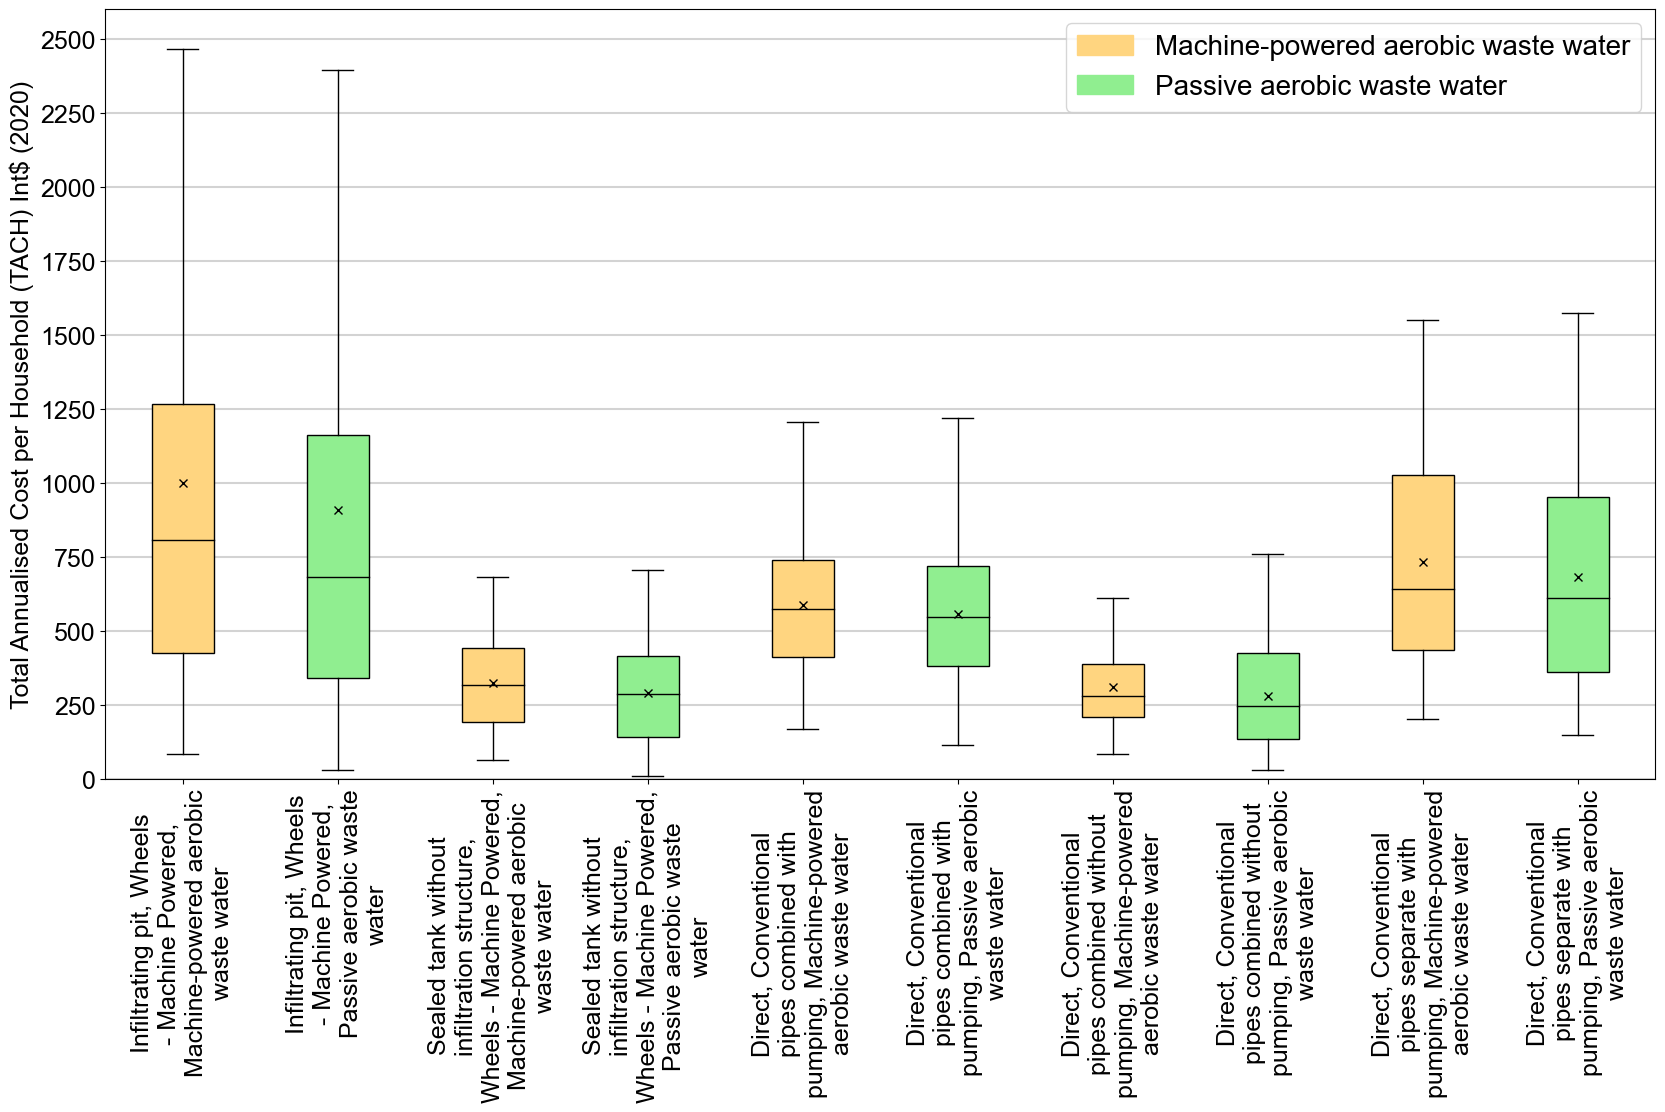

In [24]:
# create canvas to draw figure
fig, ax = plt.subplots(figsize=(20, 10))

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 18

# put background color as white
fig.patch.set_facecolor('white') 

# set Y axis ranges
ax.set_ylim(ytick_range[0], ytick_range[1])  
ax.set_yticks(np.arange(ytick_range[0], ytick_range[1],ytick_range[2]))

# draw horizontal lines for each 250 Int$
for ylabel in np.arange(0,2600,250):
    ax.axhline(y=ylabel, color='lightgray')

# Loop by the above 10 groups
for j, group in enumerate(groups):
    label = group_labels[j]
    tachs = group[1]['tach']
    color = group[1]['color'][0]
    position = j + 1
    print(f"{position}: Draw {len(tachs)} of TACH values for {label}")
    drawBoxplot(ax, tachs, position, color)

# draw labels for yticks
ax.set_ylabel(ytickLabel, fontsize=labelFontSize)

    
# draw labels for xticks.
xtick_labels = [ '\n'.join(textwrap.wrap(label, 25)) for label in group_labels ]
ax.set_xticks(np.arange(len(xtick_labels)) + 1)
ax.set_xticklabels(xtick_labels,  rotation=90, ha='center', fontsize=labelFontSize)

# draw legend
legend_labels = [
    'Machine-powered aerobic waste water',
    'Passive aerobic waste water'
]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax.legend(handles=legend_patches, loc='upper right', fontsize=legendFontSize)

# save figures as PDF and PNG
plt.savefig(file_path, format="pdf", dpi=dpi, transparent=True, bbox_inches='tight')
plt.savefig(f"{file_path}.png", format="png", dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()